In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import gudhi as gd

processed_images = torch.load('train_processed_images.pt')
processed_labels = torch.load('train_processed_labels.pt')
normal_images = [img.numpy().squeeze() for img, label in zip(processed_images, processed_labels) if label.item() == 0]  # 0: Normal
abnormal_images = [img.numpy().squeeze() for img, label in zip(processed_images, processed_labels) if label.item() == 1]  # 1: Abnormal



/tmp/ipykernel_234/753477332.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  processed_images = torch.load('train_processed_images.pt')
/tmp/ipykernel_234/753477332.py:9

In [17]:
!pip install opencv-python-headless


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 31.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


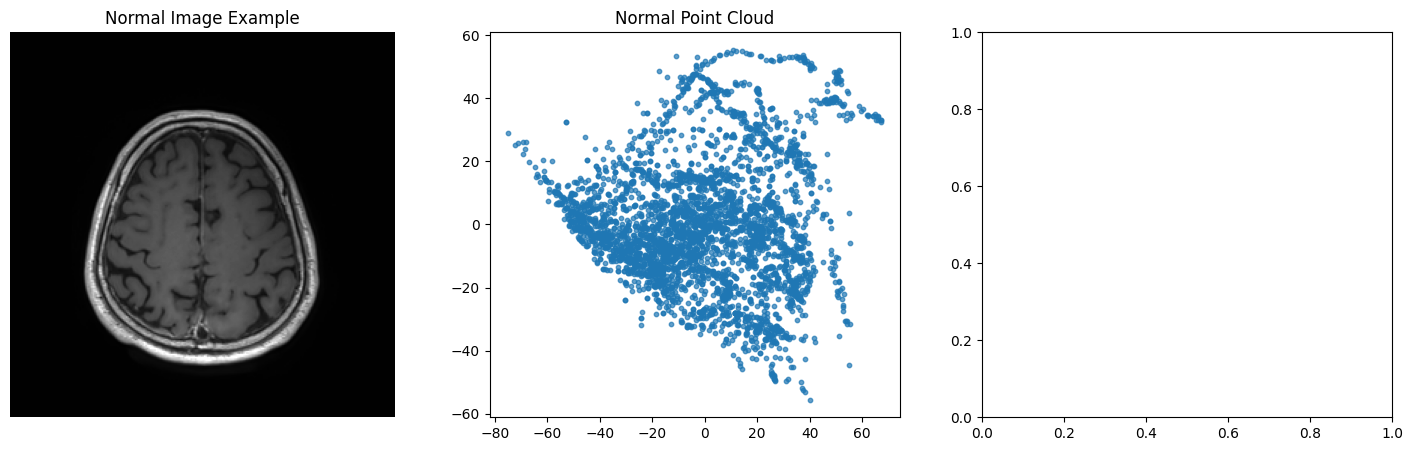

<Figure size 600x600 with 0 Axes>

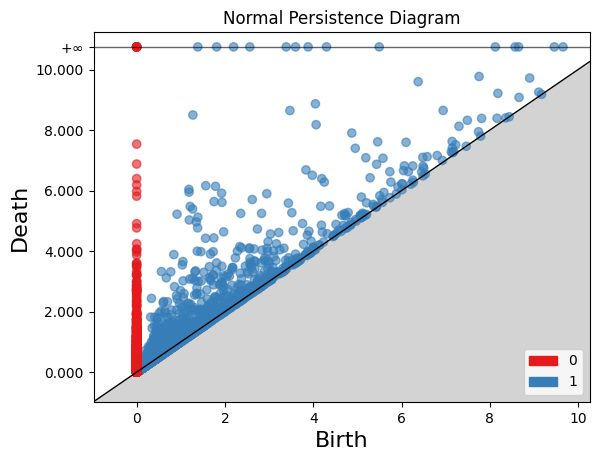

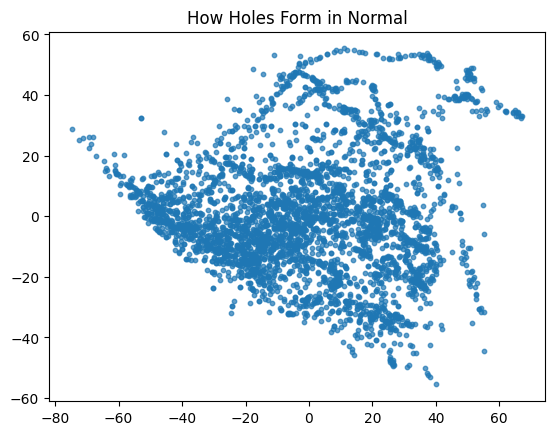

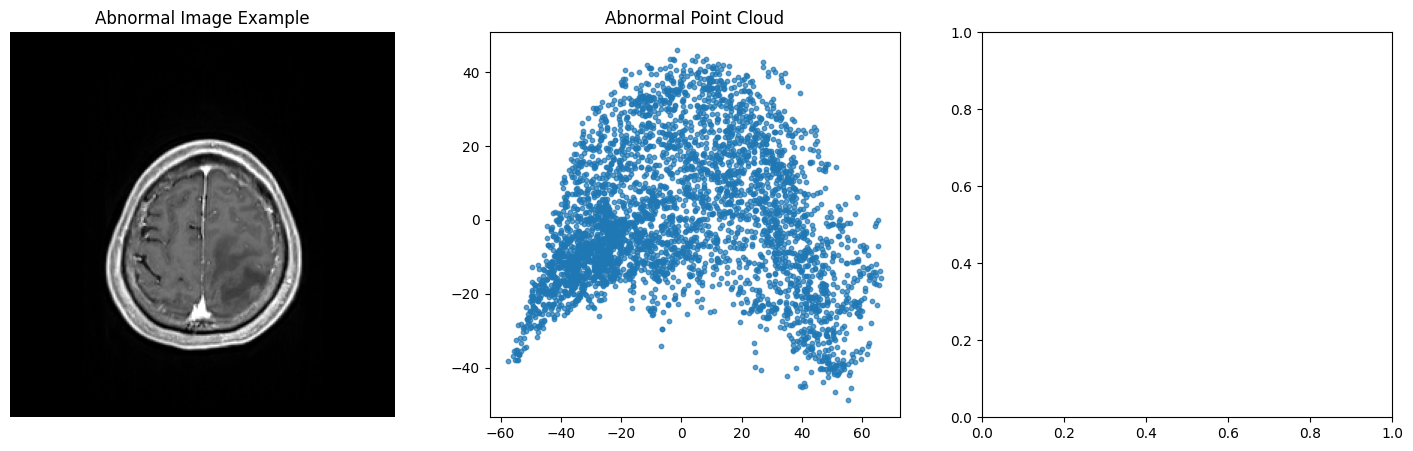

<Figure size 600x600 with 0 Axes>

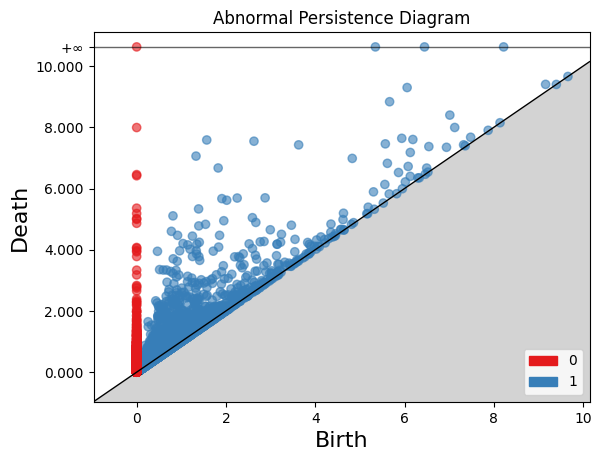

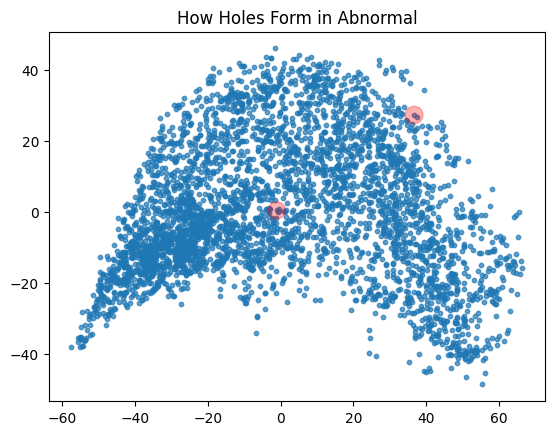

In [8]:
def visualize_topology(images, title):

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    axes[0].imshow(images[0], cmap='gray')  # 첫 번째 이미지 출력
    axes[0].set_title(f"{title} Image Example")
    axes[0].axis('off')
    
    # 포인트 클라우드
    flattened_images = [img.flatten() for img in images]
    pca = PCA(n_components=2)
    point_cloud = pca.fit_transform(flattened_images)
    

    if len(point_cloud) == 0 or np.isnan(point_cloud).any():
        print(f"Error: Point cloud is empty or contains NaN for {title}")
        return


    axes[1].scatter(point_cloud[:, 0], point_cloud[:, 1], s=10, alpha=0.7)
    axes[1].set_title(f"{title} Point Cloud")
    

    alpha_complex = gd.AlphaComplex(points=point_cloud)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=10.0)
    
    # Simplex Tree 필터링
    filtration = list(simplex_tree.get_filtration())
    if len(filtration) == 0:
        print(f"Error: Simplex tree is empty for {title}")
        return
    
    diag = simplex_tree.persistence()
    
    # Persistence Diagram
    plt.figure(figsize=(6, 6))  # 별도의 figure 생성
    gd.plot_persistence_diagram(diag)
    plt.title(f"{title} Persistence Diagram")
    plt.show()
    

    plt.scatter(point_cloud[:, 0], point_cloud[:, 1], s=10, alpha=0.7)
    for i, (dim, (birth, death)) in enumerate(diag): 
        if dim == 1 and death > birth and i < 5:  
            radius = np.sqrt(death - birth) if death > birth else 0
            if np.isfinite(radius):  
                circle = plt.Circle((point_cloud[i % len(point_cloud), 0], point_cloud[i % len(point_cloud), 1]), 
                                     radius, color='r', alpha=0.3)
                plt.gca().add_artist(circle)
    plt.title(f"How Holes Form in {title}")
    plt.show()

# Normal과 Abnormal 각각에 대해 TDA 분석 수행 및 시각화
visualize_topology(normal_images, "Normal")
visualize_topology(abnormal_images, "Abnormal")


Pixel value range: min=-1.0, max=1.0


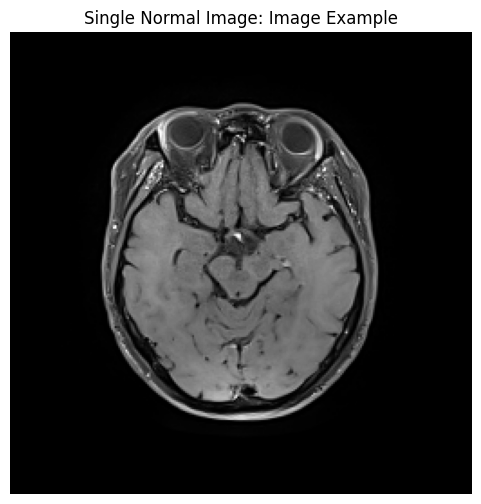

Point Cloud Shape for Single Normal Image: (10554, 2)


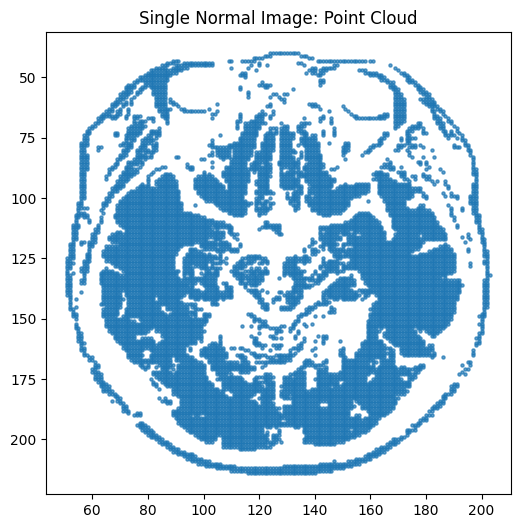

<Figure size 600x600 with 0 Axes>

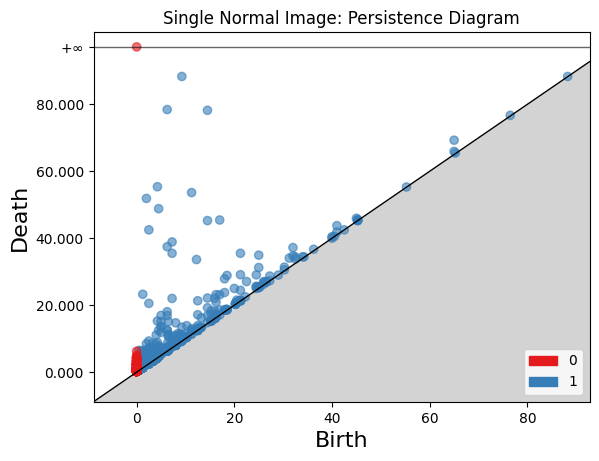

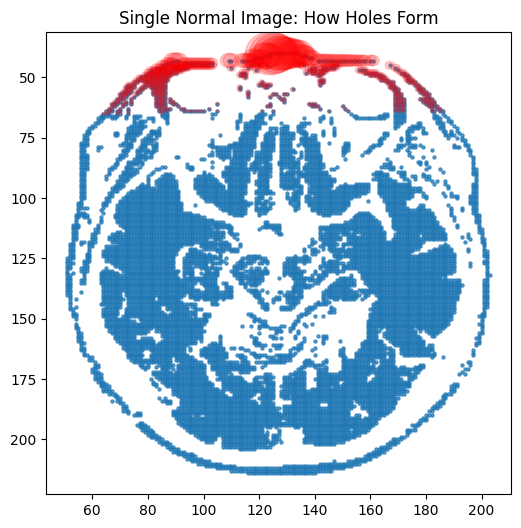

Pixel value range: min=-1.0, max=1.0


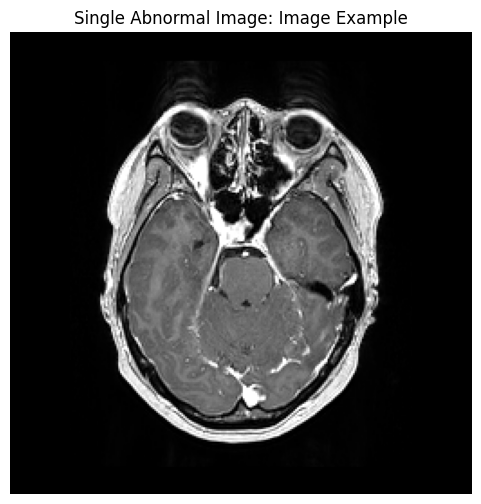

Point Cloud Shape for Single Abnormal Image: (12285, 2)


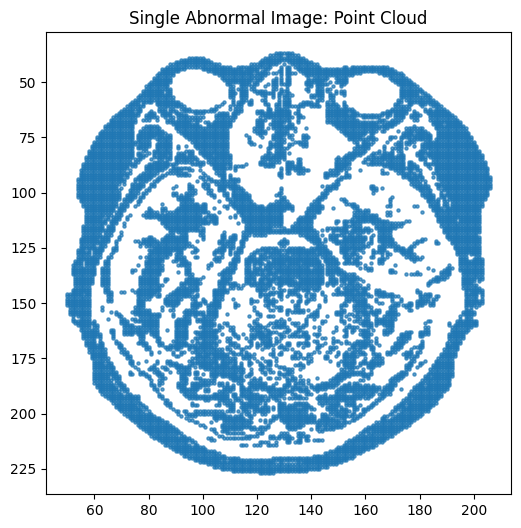

<Figure size 600x600 with 0 Axes>

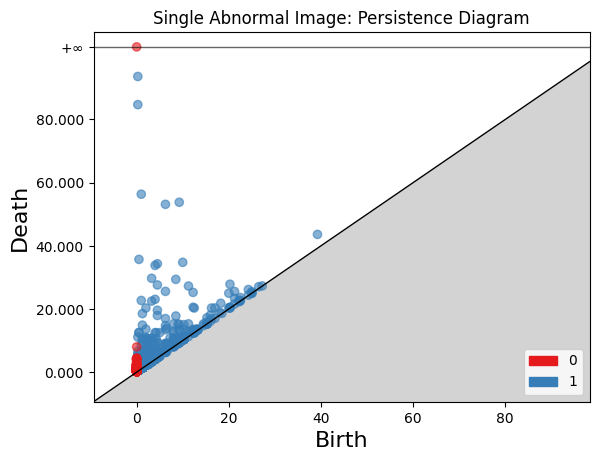

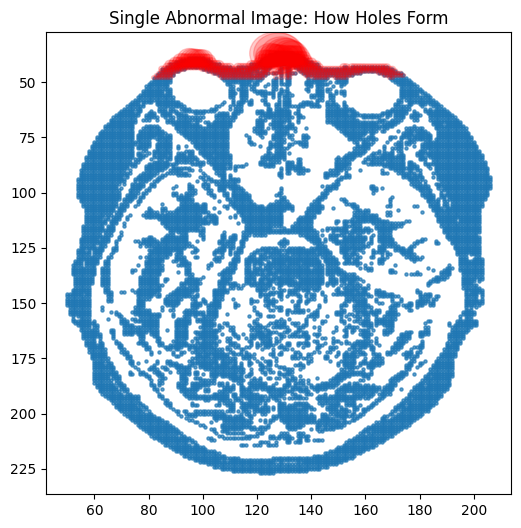

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd



def visualize_single_image_topology(image, title):
    # 0. 원본 이미지 출력
    print(f"Pixel value range: min={np.min(image)}, max={np.max(image)}")
    image 
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')  # 첫 번째 이미지 
    plt.title(f"{title}: Image Example")
    plt.axis('off')
    plt.show()
    
    # 1. 포인트 클라우드 생성
    x, y = np.where(image > -0.15)  
    point_cloud = np.stack((x, y), axis=-1)  
    
    # 포인트 클라우드
    print(f"Point Cloud Shape for {title}: {point_cloud.shape}")
    
    # 2. 포인트 클라우드 
    plt.figure(figsize=(6, 6))
    plt.scatter(point_cloud[:, 1], point_cloud[:, 0], s=5, alpha=0.7)  # y축과 x축 순서 변경
    plt.gca().invert_yaxis()  # 이미지 좌표계처럼 표시
    plt.title(f"{title}: Point Cloud")
    plt.show()
    
    # 3. AlphaComplex와 Persistent Homology 
    alpha_complex = gd.AlphaComplex(points=point_cloud)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=1000.0)  # max_alpha_square 설정
    diag = simplex_tree.persistence()

    # 4. Persistence Diagram 
    plt.figure(figsize=(6, 6))
    gd.plot_persistence_diagram(diag)
    plt.title(f"{title}: Persistence Diagram")
    plt.show()
    
    # 5. 구멍 형성 과정
    plt.figure(figsize=(6, 6))
    plt.scatter(point_cloud[:, 1], point_cloud[:, 0], s=5, alpha=0.7)  # y축과 x축 순서
    plt.gca().invert_yaxis()  # 이미지 좌표계처럼 표
    for i, (dim, (birth, death)) in enumerate(diag):  # dim, (birth, death)로 구조 
        if dim == 1 and death > birth and i < 500:  # 1차 구멍만
            radius = np.sqrt(death - birth)
            if np.isfinite(radius):  # 유한한 값만 시각화
                circle = plt.Circle((point_cloud[i % len(point_cloud), 1], point_cloud[i % len(point_cloud), 0]), 
                                     radius, color='r', alpha=0.2)
                plt.gca().add_artist(circle)
    plt.title(f"{title}: How Holes Form")
    plt.show()


single_image = normal_images[3]  
visualize_single_image_topology(single_image, "Single Normal Image")


single_image = abnormal_images[6]  # Abnormal 그룹
visualize_single_image_topology(single_image, "Single Abnormal Image")


[Single Normal Image] Brightness adjusted to match reference.
[Single Normal Image] Histogram equalization applied.
Pixel value range: min=-0.9989139437675476, max=1.2257750630378723


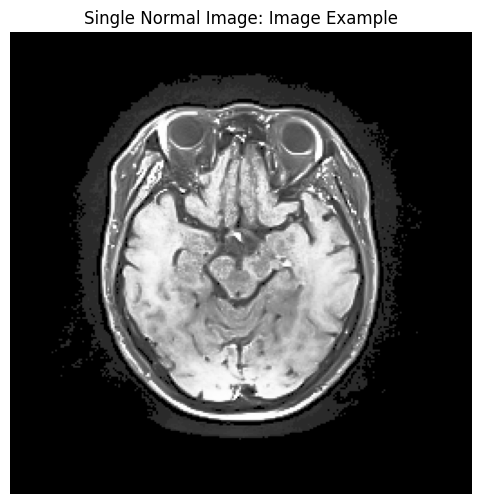

Point Cloud Shape for Single Normal Image: (17580, 2)


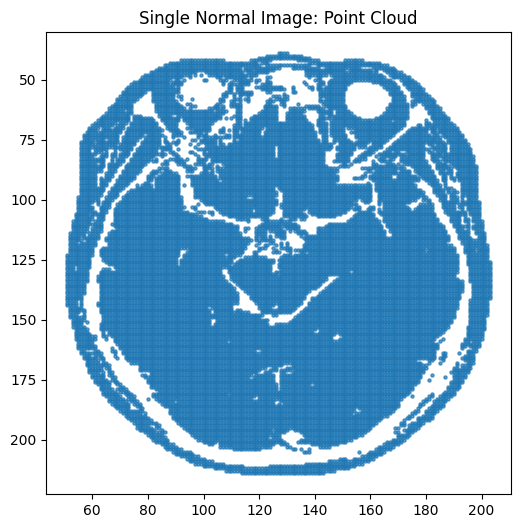

<Figure size 600x600 with 0 Axes>

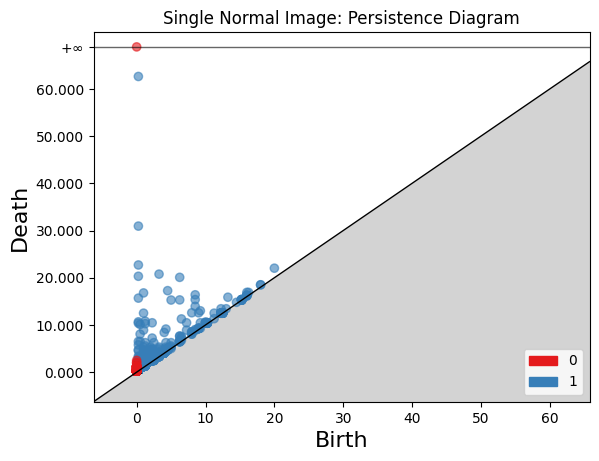

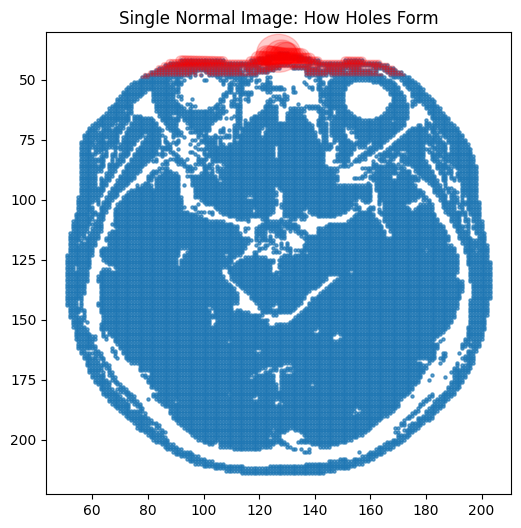

[Single Abnormal Image] Brightness adjusted to match reference.
[Single Abnormal Image] Histogram equalization applied.
[Single Abnormal Image] CLAHE applied.
Pixel value range: min=-0.9942221155353621, max=0.6348695755004883


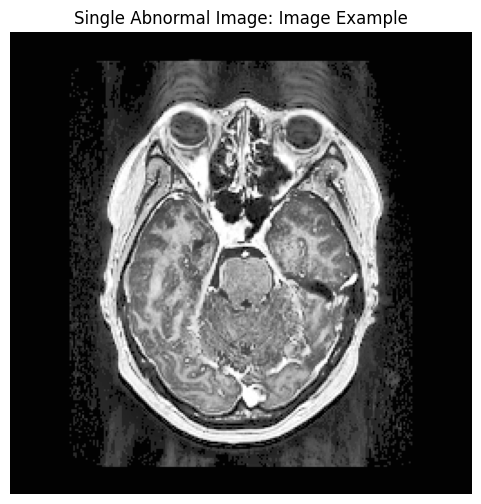

Point Cloud Shape for Single Abnormal Image: (14526, 2)


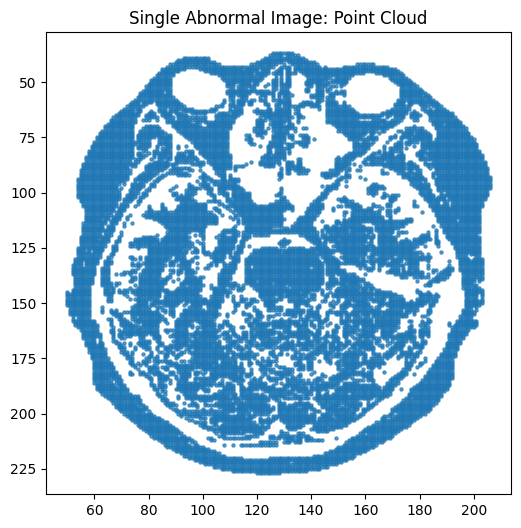

<Figure size 600x600 with 0 Axes>

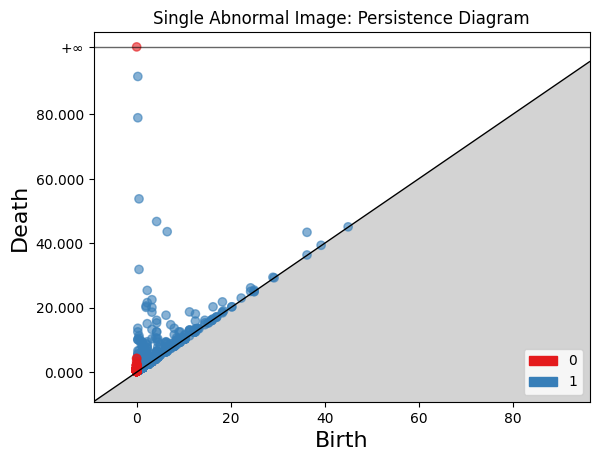

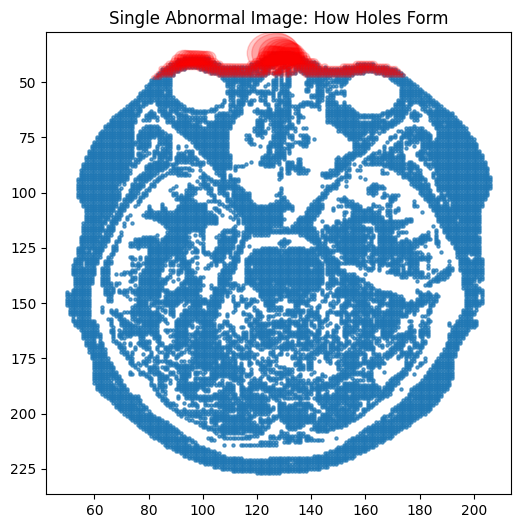

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
import cv2

# 밝기 조정
def match_brightness(image, reference):
    ref_mean = np.mean(reference)
    ref_std = np.std(reference)
    img_mean = np.mean(image)
    img_std = np.std(image)
    # 밝기와 대비를 참조 이미지와 동일하게
    adjusted_image = (image - img_mean) / img_std * ref_std + ref_mean
    return adjusted_image

# (히스토그램 평활화)
def equalize_histogram(image):
    scaled_image = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)
    equalized = cv2.equalizeHist(scaled_image)
    equalized_image = equalized / 255.0 * (np.max(image) - np.min(image)) + np.min(image)
    return equalized_image

# CLAHE 적용 
def apply_clahe_filter(image, clip_limit=2.0, grid_size=(8, 8)):
    scaled_image = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    equalized = clahe.apply(scaled_image)
    clahe_image = equalized / 255.0 * (np.max(image) - np.min(image)) + np.min(image)
    return clahe_image


# 단일 이미지 TDA 시각화 
def visualize_single_image_topology(image, title, reference=None, apply_brightness=False, apply_equalization=False, apply_clahe=False):
    # 1. 밝기 
    if apply_brightness and reference is not None:
        image = match_brightness(image, reference)
        print(f"[{title}] Brightness adjusted to match reference.")

    # 2. 명암 대비 
    if apply_equalization:
        image = equalize_histogram(image)
        print(f"[{title}] Histogram equalization applied.")

    # 3. CLAHE 
    if apply_clahe:
        image = apply_clahe_filter(image)
        print(f"[{title}] CLAHE applied.")

    # 원본 이미지 
    print(f"Pixel value range: min={np.min(image)}, max={np.max(image)}")
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(f"{title}: Image Example")
    plt.axis('off')
    plt.show()
    
    # 4. 포인트 클라우드 
    ####밝기기준선
    x, y = np.where(image > -0.15)
    point_cloud = np.stack((x, y), axis=-1)
    print(f"Point Cloud Shape for {title}: {point_cloud.shape}")
    
    # 포인트 클라우드
    plt.figure(figsize=(6, 6))
    plt.scatter(point_cloud[:, 1], point_cloud[:, 0], s=5, alpha=0.7)
    plt.gca().invert_yaxis()
    plt.title(f"{title}: Point Cloud")
    plt.show()
    
    # 5. AlphaComplex와 Persistence Diagram 
    alpha_complex = gd.AlphaComplex(points=point_cloud)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=1000.0)
    diag = simplex_tree.persistence()
    
    plt.figure(figsize=(6, 6))
    gd.plot_persistence_diagram(diag)
    plt.title(f"{title}: Persistence Diagram")
    plt.show()
    

    plt.figure(figsize=(6, 6))
    plt.scatter(point_cloud[:, 1], point_cloud[:, 0], s=5, alpha=0.7)
    plt.gca().invert_yaxis()
    for i, (dim, (birth, death)) in enumerate(diag):
        if dim == 1 and death > birth and i < 500:
            radius = np.sqrt(death - birth)
            if np.isfinite(radius):
                circle = plt.Circle((point_cloud[i % len(point_cloud), 1], point_cloud[i % len(point_cloud), 0]),
                                     radius, color='r', alpha=0.2)
                plt.gca().add_artist(circle)
    plt.title(f"{title}: How Holes Form")
    plt.show()

# Normal과 Abnormal 이미지 처리 
# 단일 Normal 이미지 선택
reference_image = abnormal_images[4]  # 참조용 Normal 
single_normal_image = normal_images[3]
visualize_single_image_topology(single_normal_image, "Single Normal Image",
                                reference=reference_image,
                                apply_brightness=True,  # 밝기 조정
                                apply_equalization=True,  # 명암 대비 조정
                                apply_clahe=False)  # CLAHE 비활성화

# 단일 Abnormal 이미지 
single_abnormal_image = abnormal_images[6]
visualize_single_image_topology(single_abnormal_image, "Single Abnormal Image",
                                reference=reference_image,
                                apply_brightness=True,  # 밝기 조정
                                apply_equalization=True,  # 명암 대비 조정 비활성화
                                apply_clahe=True)  # CLAHE 활성화


# Landscape 랑 필터 안 한 버전

Pixel value range: min=-1.0, max=1.0


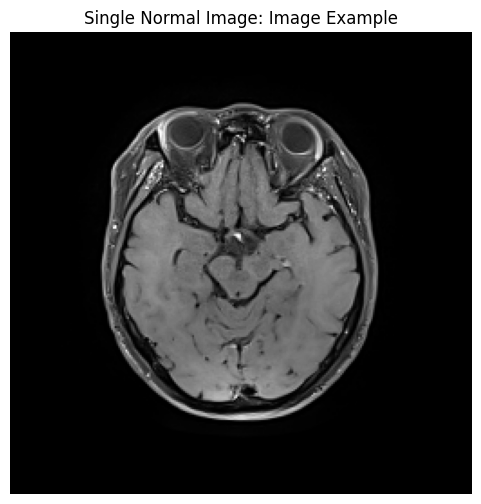

Point Cloud Shape for Single Normal Image: (10554, 2)


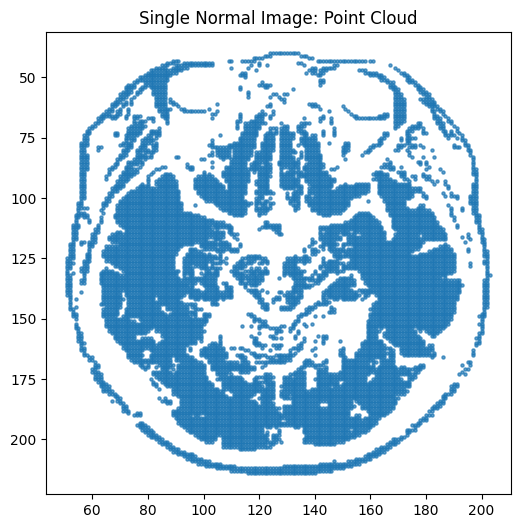

<Figure size 600x600 with 0 Axes>

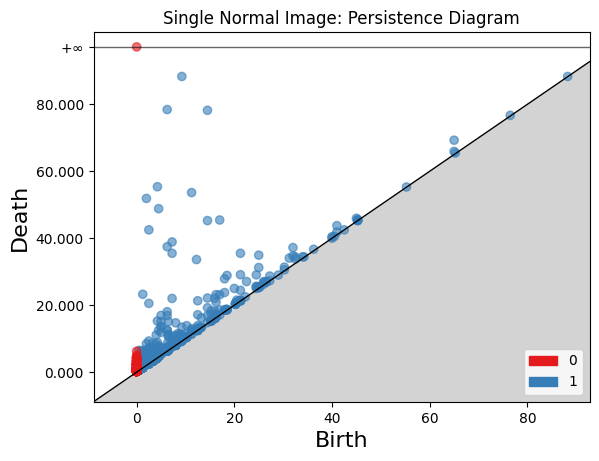

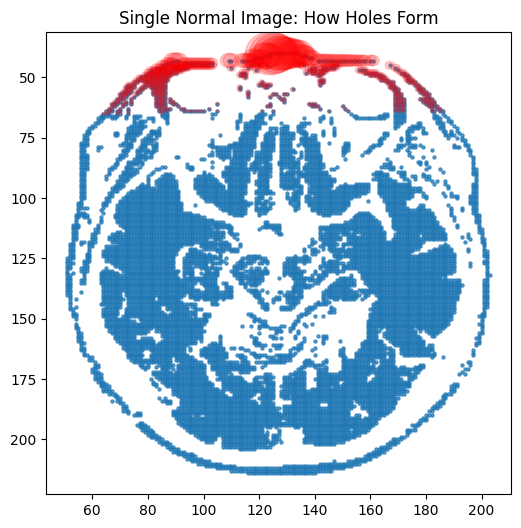

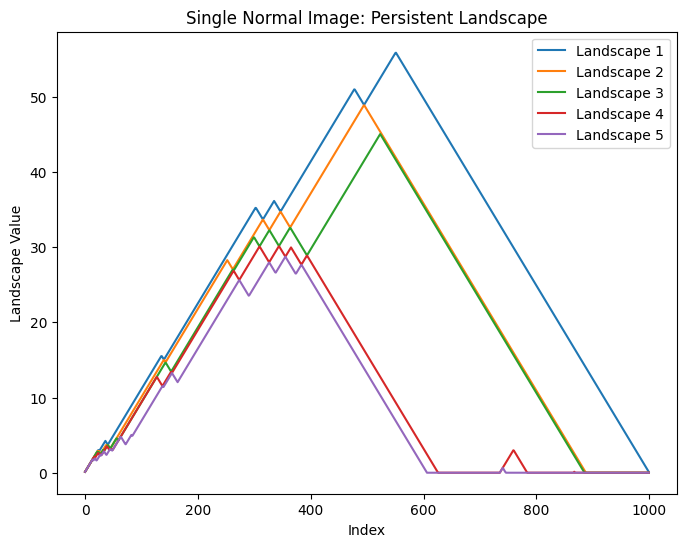

Pixel value range: min=-1.0, max=1.0


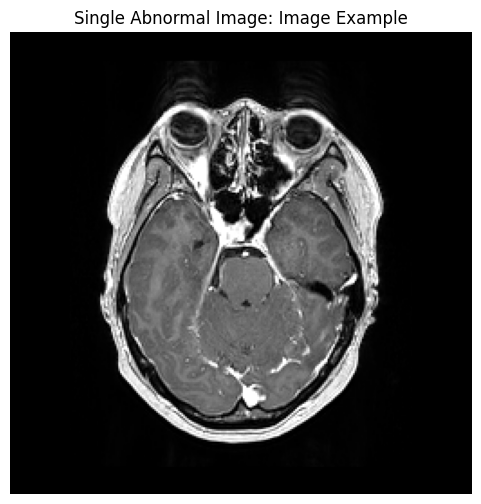

Point Cloud Shape for Single Abnormal Image: (12285, 2)


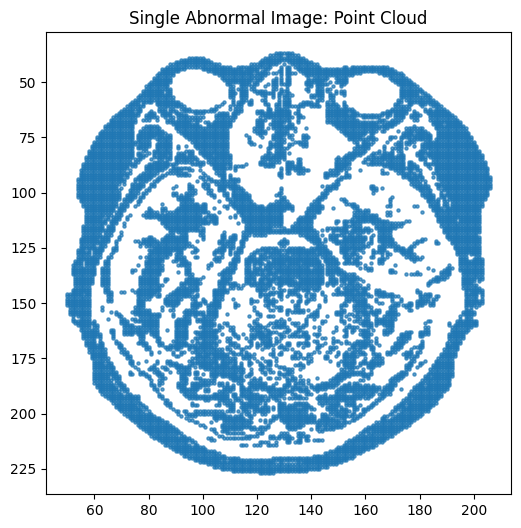

<Figure size 600x600 with 0 Axes>

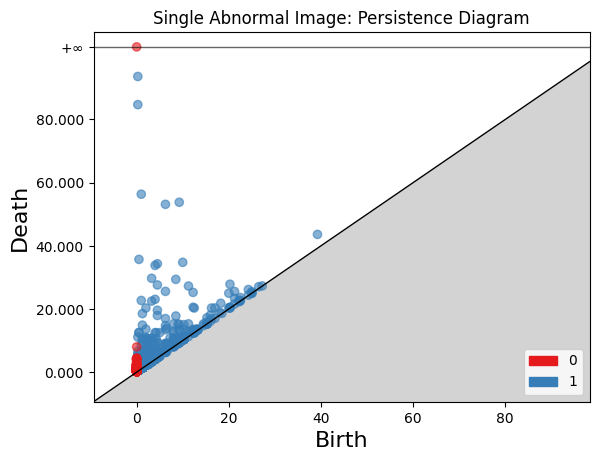

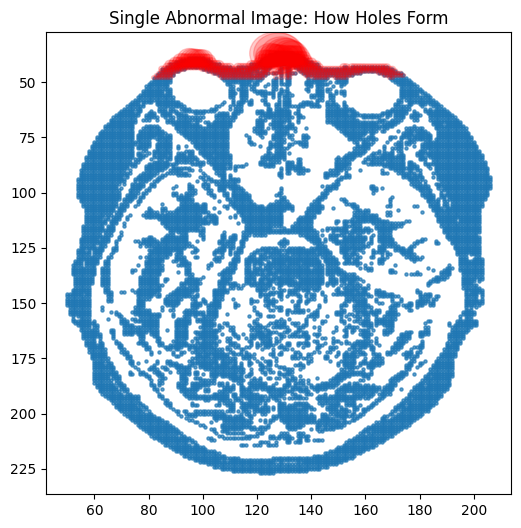

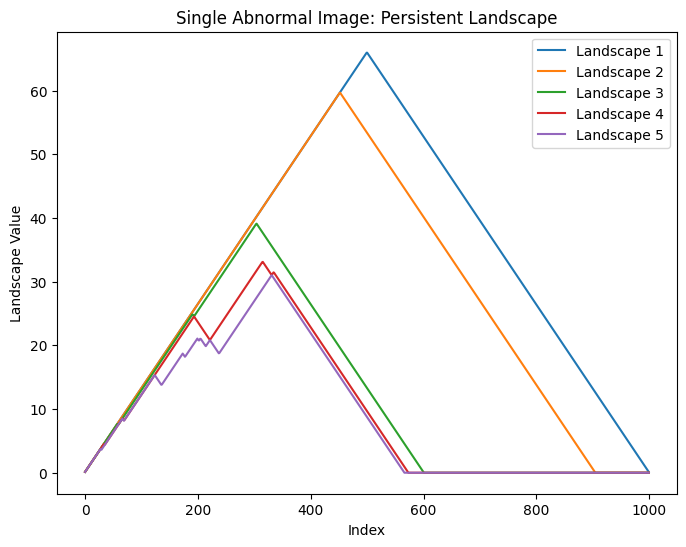

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
import gudhi.representations as gr


def visualize_single_image_topology(image, title):
 
    print(f"Pixel value range: min={np.min(image)}, max={np.max(image)}")
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(f"{title}: Image Example")
    plt.axis('off')
    plt.show()


    x, y = np.where(image > -0.15)
    point_cloud = np.stack((x, y), axis=-1)


    print(f"Point Cloud Shape for {title}: {point_cloud.shape}")


    plt.figure(figsize=(6, 6))
    plt.scatter(point_cloud[:, 1], point_cloud[:, 0], s=5, alpha=0.7)
    plt.gca().invert_yaxis()
    plt.title(f"{title}: Point Cloud")
    plt.show()


    alpha_complex = gd.AlphaComplex(points=point_cloud)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=1000.0)
    diag = simplex_tree.persistence()

    plt.figure(figsize=(6, 6))
    gd.plot_persistence_diagram(diag)
    plt.title(f"{title}: Persistence Diagram")
    plt.show()

    # 5. Visualizing How Holes Form
    plt.figure(figsize=(6, 6))
    plt.scatter(point_cloud[:, 1], point_cloud[:, 0], s=5, alpha=0.7)
    plt.gca().invert_yaxis()
    for i, (dim, (birth, death)) in enumerate(diag):
        if dim == 1 and death > birth and i < 500:
            radius = np.sqrt(death - birth)
            if np.isfinite(radius):
                circle = plt.Circle(
                    (point_cloud[i % len(point_cloud), 1], point_cloud[i % len(point_cloud), 0]),
                    radius, color='r', alpha=0.2)
                plt.gca().add_artist(circle)
    plt.title(f"{title}: How Holes Form")
    plt.show()


    filtered_diag = [(birth, death) for dim, (birth, death) in diag if dim == 1]

    if filtered_diag:

        filtered_diag_array = np.array(filtered_diag)

        landscape = gr.Landscape(num_landscapes=5, resolution=1000)
        landscapes = landscape.fit_transform([filtered_diag_array])


        plt.figure(figsize=(8, 6))
        num_landscapes = landscape.num_landscapes
        resolution = landscape.resolution


        for k in range(num_landscapes):  
            start_idx = k * resolution
            end_idx = (k + 1) * resolution
            plt.plot(landscapes[0][start_idx:end_idx], label=f"Landscape {k + 1}")
        plt.title(f"{title}: Persistent Landscape")
        plt.xlabel("Index")
        plt.ylabel("Landscape Value")
        plt.legend()
        plt.show()
    else:
        print(f"No 1-dimensional persistence features for {title}. Landscape cannot be computed.")



single_image = normal_images[3] 
visualize_single_image_topology(single_image, "Single Normal Image")


single_image = abnormal_images[6]  
visualize_single_image_topology(single_image, "Single Abnormal Image")
